In [1]:
import torch
import torchvision 
import torch.nn as nn
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt

model = torchvision.models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [2]:
def vistensor(tensor, ch=0, allkernels=False, nrow=16, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0]//nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.show()

torch.Size([64, 3, 11, 11])


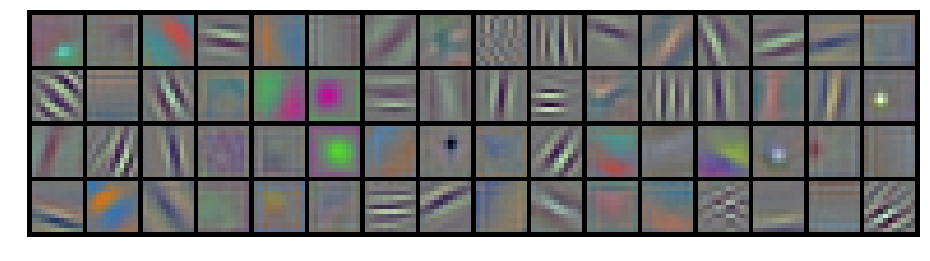

In [3]:
ik = 0
kernel = model.features[ik].weight.data.clone()
print(kernel.shape)
vistensor(kernel)

torch.Size([192, 64, 5, 5])


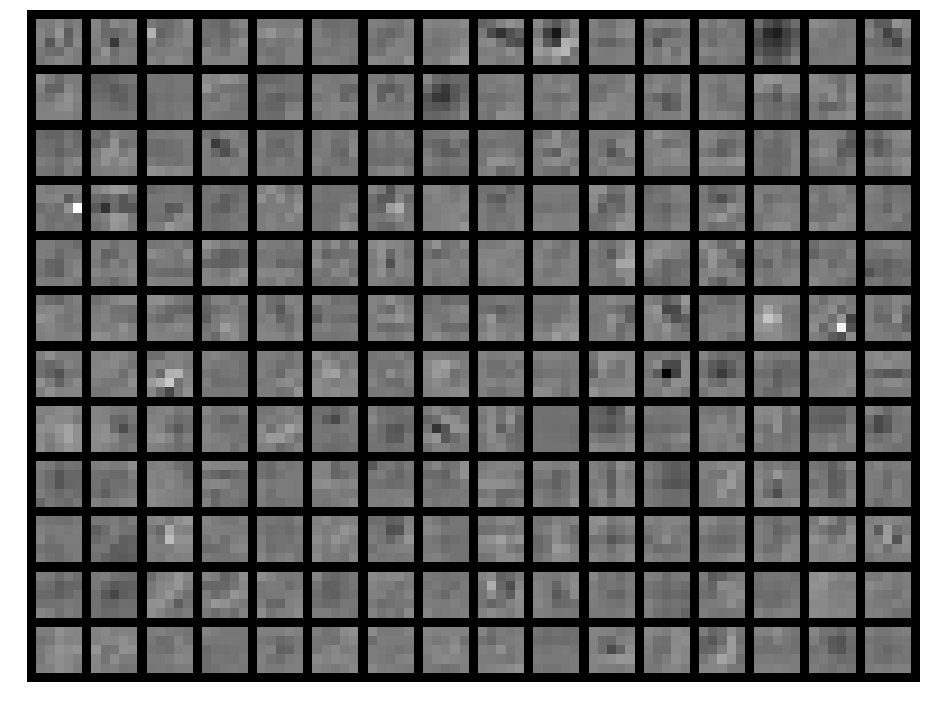

In [4]:
ik = 3
kernel = model.features[ik].weight.data.clone()
print(kernel.shape)
vistensor(kernel)

In [5]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

torch.Size([64, 3, 3, 3])


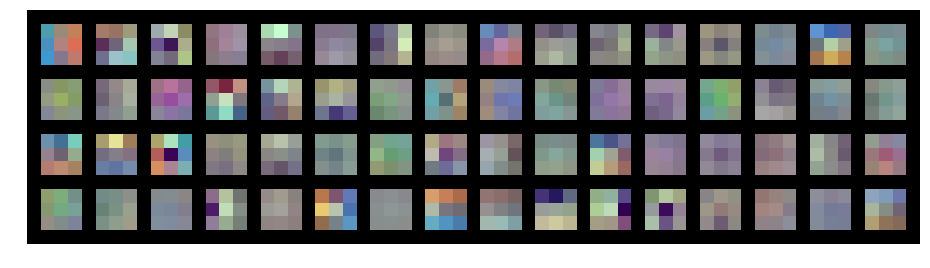

In [6]:
ik = 0
kernel = model.features[ik].weight.data.clone()
print(kernel.shape)
vistensor(kernel)

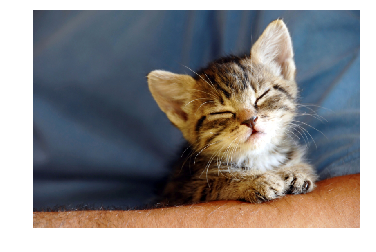

In [7]:
from PIL import Image

img = Image.open("./cat.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

def filter_outputs(model, image, layer_to_visualize):
    for index, layer in enumerate(model.features):
        image = layer(image)
        if index == layer_to_visualize:
            break
    vistensor(image.data.clone(), allkernels=True, padding=5)

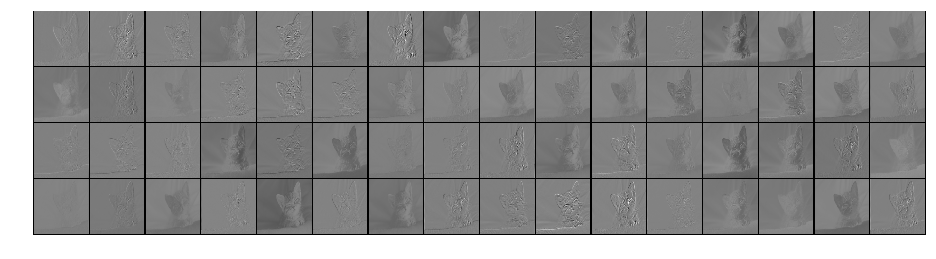

In [9]:
filter_outputs(model, trans(img).unsqueeze(0), 0)

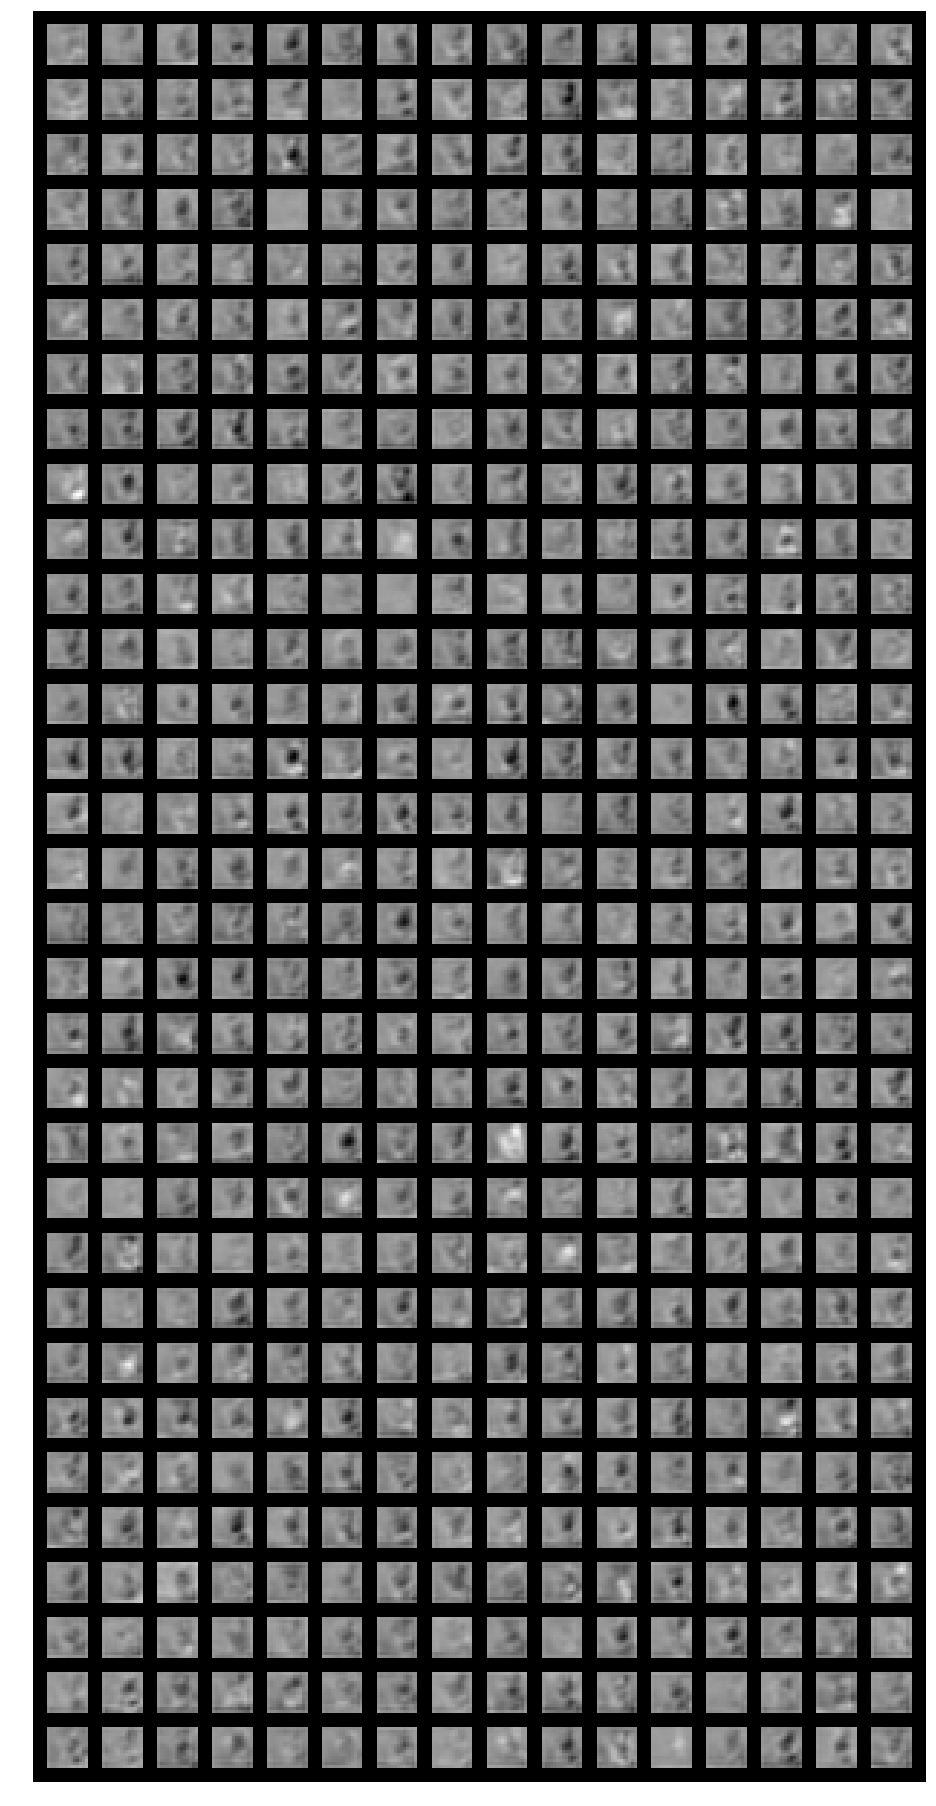

In [10]:
filter_outputs(model, trans(img).unsqueeze(0), 28)

## 卷积层可视化

通过优化的方式，产生一副能让某个filter输出最大化的图，可视化出此filter对什么样的图产生响应。

In [122]:
from torch.optim import Adam

def cnn_visualize(model, selected_layer, selected_filter, epoch=30, lr=0.1, weight_decay=1e-6):
    random_image = Image.fromarray(np.uint8(np.random.uniform(150, 180, (224, 224, 3))))
    input_image = trans(random_image).unsqueeze(0)
    input_image.requires_grad = True
    optimizer = Adam([input_image], lr=lr, weight_decay=weight_decay)
    for i in range(epoch):
        optimizer.zero_grad()
        x = input_image
        for index, layer in enumerate(model):
            x = layer(x)
            if index == selected_layer:
                break
        activation = x[0, selected_filter]
        loss = -torch.mean(activation)
        print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
        loss.backward(retain_graph=True)
        optimizer.step()
        
    return input_image.squeeze(0)

In [57]:
trans_back = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[-0.485, -0.456, -0.406],
        std=[1/0.229, 1/0.224, 1/0.225]
    ),
    torchvision.transforms.ToPILImage()
])

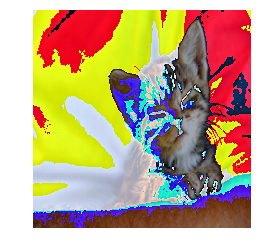

In [30]:
t = trans(img)
t = trans_back(t)
plt.imshow(t)
plt.axis('off')
plt.show()

In [31]:
trans_back = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0, 0, 0],
        std=[1/0.229, 1/0.224, 1/0.225]
    ),
    torchvision.transforms.Normalize(
        mean=[-0.485, -0.456, -0.406],
        std=[1, 1, 1]
    ),
    torchvision.transforms.ToPILImage()
])

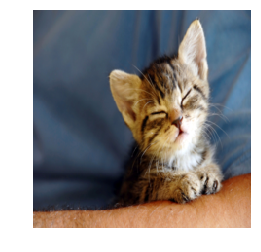

In [32]:
t = trans(img)
t = trans_back(t)
plt.imshow(t)
plt.axis('off')
plt.show()

Iteration: 0 Loss: 0.79
Iteration: 1 Loss: 0.73
Iteration: 2 Loss: 0.67
Iteration: 3 Loss: 0.62
Iteration: 4 Loss: 0.56
Iteration: 5 Loss: 0.51
Iteration: 6 Loss: 0.47
Iteration: 7 Loss: 0.43
Iteration: 8 Loss: 0.39
Iteration: 9 Loss: 0.35
Iteration: 10 Loss: 0.32
Iteration: 11 Loss: 0.28
Iteration: 12 Loss: 0.25
Iteration: 13 Loss: 0.22
Iteration: 14 Loss: 0.19
Iteration: 15 Loss: 0.16
Iteration: 16 Loss: 0.13
Iteration: 17 Loss: 0.10
Iteration: 18 Loss: 0.07
Iteration: 19 Loss: 0.04
Iteration: 20 Loss: 0.02
Iteration: 21 Loss: -0.01
Iteration: 22 Loss: -0.04
Iteration: 23 Loss: -0.07
Iteration: 24 Loss: -0.10
Iteration: 25 Loss: -0.14
Iteration: 26 Loss: -0.17
Iteration: 27 Loss: -0.20
Iteration: 28 Loss: -0.23
Iteration: 29 Loss: -0.26


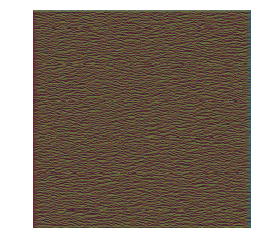

In [130]:
cnn_layer = 2
filter_pos = 1
vis_layer = trans_back(cnn_visualize(model.features, cnn_layer, filter_pos, lr=0.02, weight_decay=1e-6))
plt.imshow(vis_layer)
plt.axis('off')
plt.show()

Iteration: 0 Loss: 1.45
Iteration: 1 Loss: 0.02
Iteration: 2 Loss: -1.24
Iteration: 3 Loss: -2.38
Iteration: 4 Loss: -3.49
Iteration: 5 Loss: -4.59
Iteration: 6 Loss: -5.69
Iteration: 7 Loss: -6.83
Iteration: 8 Loss: -7.98
Iteration: 9 Loss: -9.17
Iteration: 10 Loss: -10.36
Iteration: 11 Loss: -11.55
Iteration: 12 Loss: -12.74
Iteration: 13 Loss: -13.96
Iteration: 14 Loss: -15.20
Iteration: 15 Loss: -16.44
Iteration: 16 Loss: -17.70
Iteration: 17 Loss: -18.95
Iteration: 18 Loss: -20.20
Iteration: 19 Loss: -21.45
Iteration: 20 Loss: -22.71
Iteration: 21 Loss: -23.97
Iteration: 22 Loss: -25.25
Iteration: 23 Loss: -26.55
Iteration: 24 Loss: -27.84
Iteration: 25 Loss: -29.13
Iteration: 26 Loss: -30.42
Iteration: 27 Loss: -31.72
Iteration: 28 Loss: -33.01
Iteration: 29 Loss: -34.29
Iteration: 30 Loss: -35.57
Iteration: 31 Loss: -36.84
Iteration: 32 Loss: -38.10
Iteration: 33 Loss: -39.37
Iteration: 34 Loss: -40.63
Iteration: 35 Loss: -41.88
Iteration: 36 Loss: -43.12
Iteration: 37 Loss: -44

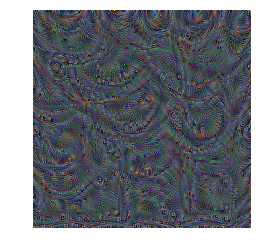

In [138]:
cnn_layer = 24
filter_pos = 6
vis_layer = trans_back(cnn_visualize(model.features, cnn_layer, filter_pos, epoch=100, lr=0.01, weight_decay=1e-6))
plt.imshow(vis_layer)
plt.axis('off')
plt.show()